# Load Forecasting SPP Data

## Load the consumption data

In [68]:
import glob

import pandas as pd

from adhoc_energy_analytics.constants import RAW_DATA_DIR

datetime_cols = [
    "UTC Timestamp (Interval Ending)",
    "Local Timestamp Central Time (Interval Beginning)",
    "Local Timestamp Central Time (Interval Ending)",
    "Local Date",
]

# Get a list of all files matching the pattern
load_act_file_list = glob.glob(f"{RAW_DATA_DIR}/spp_load_act_hr_*")

# Read all files into a single dataframe
load_act_df_list = [
    pd.read_csv(file, skiprows=3, parse_dates=datetime_cols)
    for file in load_act_file_list
]
load_act_df = pd.concat(load_act_df_list, ignore_index=True)

# Load temperature data
temp_file_list = glob.glob(f"{RAW_DATA_DIR}/spp_temp_hr_*")
temp_df_list = [
    pd.read_csv(file, skiprows=3, parse_dates=datetime_cols) for file in temp_file_list
]
temp_df = pd.concat(temp_df_list, ignore_index=True)

# Load forecast data
load_for_file_list = glob.glob(f"{RAW_DATA_DIR}/spp_load_for_hr_*")
load_for_df_list = [
    pd.read_csv(file, skiprows=3, parse_dates=datetime_cols)
    for file in load_for_file_list
]
load_for_df = pd.concat(load_for_df_list, ignore_index=True)

df = load_act_df.merge(temp_df, on=["Local Date", "Hour Number"], suffixes=("", "_y"))
df = df.merge(load_for_df, on=["Local Date", "Hour Number"], suffixes=("", "_y"))

# Remove columns with suffixes
df = df[[col for col in df.columns if not col.endswith("_y")]]

print("Data loaded successfully")
len(load_act_df), len(temp_df), len(load_for_df), len(df)

Data loaded successfully


(33818, 36671, 33791, 33391)

### Where is the difference coming from?

In [67]:
# Count the number of values per year for each dataset
load_act_counts = (
    load_act_df["UTC Timestamp (Interval Ending)"].dt.year.value_counts().sort_index()
)
temp_counts = (
    temp_df["UTC Timestamp (Interval Ending)"].dt.year.value_counts().sort_index()
)
load_for_counts = (
    load_for_df["UTC Timestamp (Interval Ending)"].dt.year.value_counts().sort_index()
)

# Create a dictionary with the counts
data_counts = {
    "Year": load_act_counts.index,
    "Load Actual": load_act_counts.values,
    "Temperature": temp_counts.values,
    "Load Forecast": load_for_counts.values,
}

# Convert the dictionary to a dataframe
data_counts_df = pd.DataFrame(data_counts)

# Set the index to the dataframe names
data_counts_df.set_index("Year", inplace=True)

print(data_counts_df)

      Load Actual  Temperature  Load Forecast
Year                                         
2021         7814         8751           7769
2022         8725         8689           8736
2023         7341         8756           7320
2024         8228         8739           8208
2025         1710         1736           1758


## Data Exploration

### How many years of data do we have?

In [ ]:
# Extract the unique years from the 'UTC Timestamp (Interval Ending)' column
years = df["UTC Timestamp (Interval Ending)"].dt.year.unique()

# Calculate the number of unique years
num_years = len(years)
print(f"We have {num_years} years of data.")

We have 5 years of data.


### Which demand regions are available?

* CSWS – Public Service Company of Oklahoma (PSO) / Southwestern Electric Power Company (SWEPCO) (Part of AEP - American Electric Power)
* EDE – Empire District Electric Company
* GRDA – Grand River Dam Authority (Oklahoma)
* INDN – City of Independence, Missouri (Independence Power & Light)
* KACY – Kansas City Board of Public Utilities (Kansas City, KS)
* KCPL – Kansas City Power & Light (Now Evergy)
* LES – Lincoln Electric System (Nebraska)
* MPS – Missouri Public Service (Now part of Evergy)
* NPPD – Nebraska Public Power District
* OKGE – Oklahoma Gas & Electric (OG&E)
* OPPD – Omaha Public Power District (Nebraska)
* SECI – Sunflower Electric Cooperative, Inc. (Kansas)
* SPRM – Springfield, Missouri City Utilities
* SPS – Southwestern Public Service Company (Xcel Energy - serving parts of Texas, New Mexico, Oklahoma, and Kansas)
* WAUE – Western Area Power Administration, Upper Great Plains (WAPA-UGP)
* WFEC – Western Farmers Electric Cooperative (Oklahoma & surrounding states)
* WR – Westar Energy (now part of Evergy)

In [43]:
# Extract columns that contain 'Actual Load (MW)'
load_columns = [col for col in df.columns if "Actual Load (MW)" in col]

# Print the locations
locations = [col.strip().split(" ")[0] for col in load_columns]
print("Tracked locations:", locations)

Tracked locations: ['SPP', 'CSWS', 'EDE', 'GRDA', 'INDN', 'KACY', 'KCPL', 'LES', 'MPS', 'NPPD', 'OKGE', 'OPPD', 'SECI', 'SPRM', 'SPS', 'WAUE', 'WFEC', 'WR']


### What does the load for KCPL look like over the past 2 weeks?

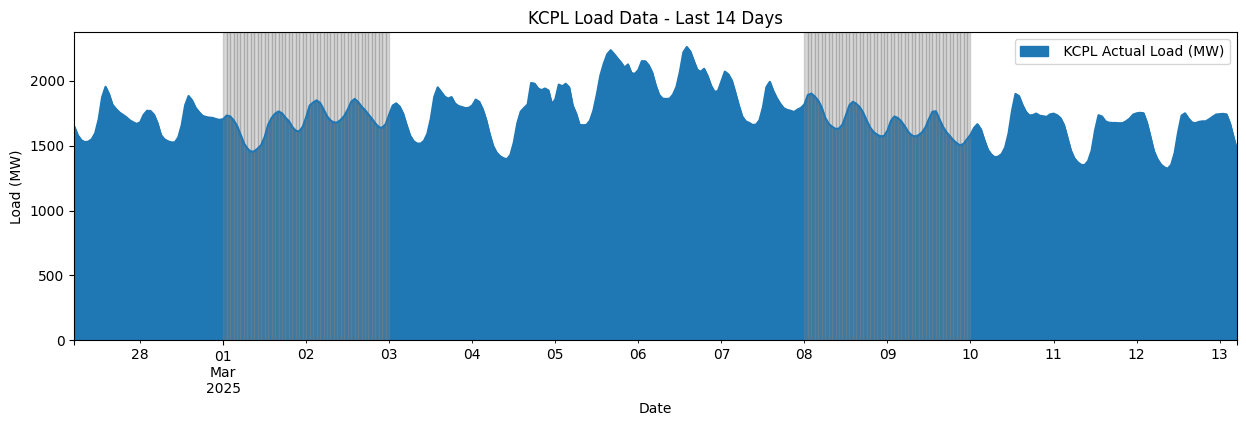

In [44]:
import matplotlib.pyplot as plt

# Filter the dataframe for the last 14 days
recent_14_days = df[
    df["UTC Timestamp (Interval Ending)"]
    >= (df["UTC Timestamp (Interval Ending)"].max() - pd.Timedelta(days=14))
]

# Select the relevant columns
kcpl_recent_14_days = recent_14_days[
    ["UTC Timestamp (Interval Ending)", " KCPL Actual Load (MW)"]
]

# Plot the data as an area chart with increased width
ax = kcpl_recent_14_days.plot(
    x="UTC Timestamp (Interval Ending)",
    y=" KCPL Actual Load (MW)",
    kind="area",
    title="KCPL Load Data - Last 14 Days",
    figsize=(15, 4),  # Increase the width of the chart
)

# Highlight weekends
for index, row in kcpl_recent_14_days.iterrows():
    # 5 = Saturday, 6 = Sunday
    if row["UTC Timestamp (Interval Ending)"].weekday() >= 5:
        ax.axvspan(
            row["UTC Timestamp (Interval Ending)"],
            row["UTC Timestamp (Interval Ending)"] + pd.Timedelta(hours=1),
            color="gray",
            alpha=0.3,
        )

plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.show()

### How does the load differ between weekdays and weekends?

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_24849/2542237093.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_year["Day Type"] = past_year["UTC Timestamp (Interval Ending)"].dt.dayofweek.apply(


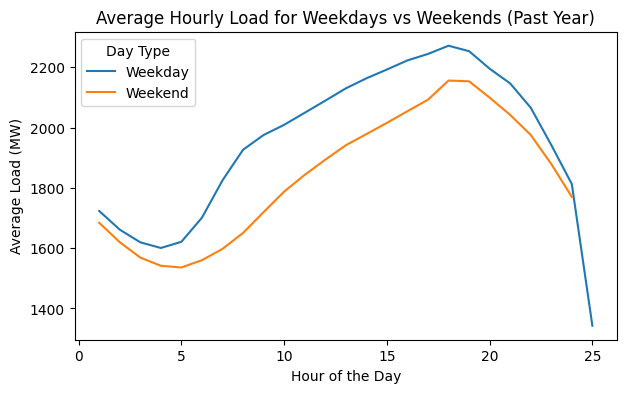

In [34]:
# Filter the dataframe for the past year
past_year = df[
    df["UTC Timestamp (Interval Ending)"]
    >= (df["UTC Timestamp (Interval Ending)"].max() - pd.DateOffset(years=1))
]

# Create 'Day Type' column
past_year["Day Type"] = past_year["UTC Timestamp (Interval Ending)"].dt.dayofweek.apply(
    lambda x: "Weekend" if x >= 5 else "Weekday"
)

# Group the data by 'Hour Number' and 'Day Type' and calculate the mean load
average_hourly_load = (
    past_year.groupby(["Hour Number", "Day Type"])[" KCPL Actual Load (MW)"]
    .mean()
    .unstack()
)

# Plot the average hourly load for weekdays and weekends
average_hourly_load.plot(
    kind="line",
    figsize=(7, 4),
    title="Average Hourly Load for Weekdays vs Weekends (Past Year)",
)
plt.xlabel("Hour of the Day")
plt.ylabel("Average Load (MW)")
plt.show()

In [36]:
# Calculate the average load for weekdays and weekends
average_load = past_year.groupby("Day Type")[" KCPL Actual Load (MW)"].mean()

# Print the results
print("Average Load (MW):")
print(average_load)

# Calculate the absolute difference
absolute_difference = average_load["Weekday"] - average_load["Weekend"]
print(f"\nAbsolute Difference (MW): {absolute_difference:.2f}")

# Calculate the percentage difference
percentage_difference = (absolute_difference / average_load["Weekend"]) * 100
print(f"Percentage Difference: {percentage_difference:.2f}%")

# Determine which day type has higher load
if average_load["Weekday"] > average_load["Weekend"]:
    print("\nLoad is higher on weekdays.")
else:
    print("\nLoad is higher on weekends.")

Average Load (MW):
Day Type
Weekday    1976.624387
Weekend    1840.104333
Name:  KCPL Actual Load (MW), dtype: float64

Absolute Difference (MW): 136.52
Percentage Difference: 7.42%

Load is higher on weekdays.


### How about seasonality?

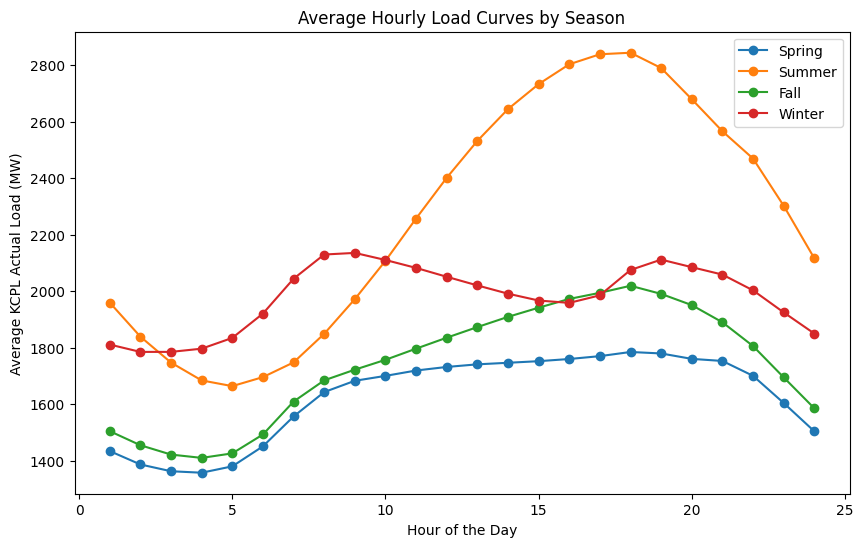

In [70]:
# Create a mapping from month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# Create a 'Season' column in df using the 'Local Date' column
df["Season"] = df["Local Date"].dt.month.apply(month_to_season)

# Group by season and hour to compute average load for KCPL
avg_hourly_load = df.groupby(["Season", "Hour Number"])[" KCPL Actual Load (MW)"].mean().reset_index()

# Plot the load curves for each season
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for season in ["Spring", "Summer", "Fall", "Winter"]:
    season_data = avg_hourly_load[avg_hourly_load["Season"] == season]
    plt.plot(season_data["Hour Number"], season_data[" KCPL Actual Load (MW)"],
             marker='o', label=season)

plt.xlabel("Hour of the Day")
plt.ylabel("Average KCPL Actual Load (MW)")
plt.title("Average Hourly Load Curves by Season")
plt.legend()
plt.show()